**19/12/2021**
<br>
Bruno Mazzilli González

> # Modelo Base y Train-Test Set:

En este notebook vamos a crear los data sets correspondientes a train y a test. Además se va a entrenar el modelo 'base' para tener un 'benchmark' con los demás modelos que vayamos creando.

### Librerias

In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt # plots
import seaborn as sns # plots
from sklearn.ensemble import IsolationForest
from sklearn import preprocessing 
from sklearn.linear_model import Lasso, LassoCV
import pickle
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression # Log Regression
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn import datasets, metrics, model_selection

import warnings
warnings.filterwarnings("ignore")

### Importamos datos

In [2]:
final_df = pd.read_parquet('data/c_sev_df_final.parquet')

In [3]:
final_df['target_c_sev'].value_counts()

0    4914502
1      81717
Name: target_c_sev, dtype: int64

In [4]:
print(final_df.shape)
final_df.info(verbose=True)

(4996219, 101)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4996219 entries, 0 to 4996218
Data columns (total 101 columns):
 #    Column        Dtype  
---   ------        -----  
 0    C_WTHR_2.0    uint8  
 1    C_RSUR_7.0    uint8  
 2    C_TRAF_7.0    uint8  
 3    V_TYPE_7.0    uint8  
 4    C_TRAF_10.0   uint8  
 5    P_PSN_31.0    uint8  
 6    C_CONF_33.0   uint8  
 7    C_RSUR_3.0    uint8  
 8    C_RSUR_6.0    uint8  
 9    C_MNTH        float64
 10   C_TRAF_4.0    uint8  
 11   C_TRAF_8.0    uint8  
 12   V_TYPE_10.0   uint8  
 13   V_TYPE_21.0   uint8  
 14   C_TRAF_12.0   uint8  
 15   C_TRAF_13.0   uint8  
 16   C_CONF_5.0    uint8  
 17   C_VEHS_26.0   uint8  
 18   V_TYPE_18.0   uint8  
 19   C_VEHS_15.0   uint8  
 20   C_CONF_25.0   uint8  
 21   C_RALN_4.0    uint8  
 22   C_VEHS_14.0   uint8  
 23   C_VEHS_46.0   uint8  
 24   C_WTHR_7.0    uint8  
 25   V_TYPE_9.0    uint8  
 26   C_VEHS_18.0   uint8  
 27   P_USER_4.0    uint8  
 28   C_VEHS_10.0   uint8  
 29

In [5]:
final_df.select_dtypes(include=['float64','int64']).head(3)

,C_MNTH,V_YEAR,C_HOUR,C_YEAR,target_c_sev
0,1.0,1990.0,20.0,1999,0
1,1.0,1987.0,20.0,1999,0
2,1.0,1987.0,20.0,1999,0


#### Escalamos los Datos

In [6]:
#creamos df con las variables que queremos escalar
escalar = final_df[['C_MNTH','V_YEAR','C_HOUR','C_YEAR']]

In [7]:
#escalamos datos y trasformamos los datos a un df
scaler = MinMaxScaler()  # escalamos los datos                                     
variables_escaladas = pd.DataFrame(scaler.fit_transform(escalar), columns = escalar.columns) 
variables_escaladas.tail()

,C_MNTH,V_YEAR,C_HOUR,C_YEAR
4996214,1.0,0.938596,0.608696,1.0
4996215,1.0,0.938596,0.608696,1.0
4996216,1.0,0.877193,0.826087,1.0
4996217,1.0,0.877193,0.826087,1.0
4996218,1.0,0.877193,0.826087,1.0


In [8]:
df_scaled = pd.concat([variables_escaladas, final_df.drop(columns = ['C_MNTH','V_YEAR','C_HOUR','C_YEAR'])],axis=1)
df_scaled.head()

,C_MNTH,V_YEAR,C_HOUR,C_YEAR,C_WTHR_2.0,C_RSUR_7.0,C_TRAF_7.0,V_TYPE_7.0,C_TRAF_10.0,P_PSN_31.0,...,P_ISEV_2.0,C_RSUR_9.0,C_VEHS_13.0,P_PSN_97.0,C_CONF_23.0,C_CONF_4.0,C_VEHS_44.0,C_VEHS_35.0,P_PSN_21.0,target_c_sev
0,0.0,0.780702,0.869565,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.754386,0.869565,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.754386,0.869565,0.0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0.0,0.745614,0.347826,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.728070,0.739130,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df_scaled.shape

(4996219, 101)

In [24]:
df_scaled.to_parquet('data/df_scaled.parquet')

In [10]:
X = df_scaled.drop("target_c_sev", axis= 1)

In [11]:
y = df_scaled["target_c_sev"]

<br>

### Train & Test Set

Para entrenar los modelos y poder evaluarlos tenemos que dividir el conjunto de datos en dos partes, train y test. Del EDA sabemos que el conjunto de datos está desequilibrado. Para resolver ese problema, aplicaremos un método de sobremuestreo llamado Smote. La función Smote crea muestras sintéticas de la clase minoritaria haciendo que la clase minoritaria sea igual a la mayoritaria. Para ello, Smote selecciona registros similares.

In [18]:
%%time

# Separamos en train y test
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.30, random_state=1)

# Utilizamos smote para balancear la muestra
sm = SMOTE(random_state=0,sampling_strategy = 0.4)

# solo se realiza smote sobre la parte train set
X_train, Y_train = sm.fit_resample(X_train, Y_train) 


print(X_train.shape); print(X_test.shape); print(Y_train.shape); print(Y_test.shape)

(4816257, 100)
(1498866, 100)
(4816257,)
(1498866,)
CPU times: user 1min 40s, sys: 35.3 s, total: 2min 15s
Wall time: 2min 10s


Comprobamos que los datos estan mas balanceados

In [19]:
Y_train.value_counts(normalize=True)

0    0.714286
1    0.285714
Name: target_c_sev, dtype: float64

In [20]:
Y_test.value_counts(normalize=True)

0    0.983622
1    0.016378
Name: target_c_sev, dtype: float64

Pasamos los datos procesados a la carpeta 'data' para utilizar los mismos datos en todos los modelos:

In [21]:
X_train.to_parquet('data/x_train.parquet')

X_test.to_parquet('data/x_test.parquet')

In [22]:
Y_train = pd.DataFrame(Y_train,columns=['target_c_sev'])
Y_test = pd.DataFrame(Y_test, columns=['target_c_sev'])
Y_train.to_parquet('data/y_train.parquet')
Y_test.to_parquet('data/y_test.parquet')

<br>

### Modelo Base

In [23]:
%%time
#modelo que se basa en predecir en base a la moda
base_model = DummyClassifier(strategy = 'most_frequent')

#Entrenamiento del modelo 
base_model.fit(X_train, Y_train)

CPU times: user 163 ms, sys: 33.1 ms, total: 196 ms
Wall time: 196 ms


DummyClassifier(strategy='most_frequent')

#### Matriz de Confusión

In [18]:
#Función de la matriz de confusion:
def conf_matrix(Y_test, Y_pred): # va a comparar los resultados de las predicciones de la variable target vs la real del testset
    cnf_matrix_tra = confusion_matrix(Y_test, Y_pred)
    conf_plot = sns.heatmap(cnf_matrix_tra, annot=True, cmap='Blues', fmt='g')
    bottom, top = conf_plot.get_ylim()
    conf_plot.set_ylim(bottom + 0.5, top - 0.5)
    conf_plot.set_title("Confusion matrix, without normalization")
    conf_plot.set_ylabel('True Label')
    conf_plot.set_xlabel('Predicted Label');

              precision    recall  f1-score   support

           0       0.98      1.00      0.99   1474318
           1       0.00      0.00      0.00     24548

    accuracy                           0.98   1498866
   macro avg       0.49      0.50      0.50   1498866
weighted avg       0.97      0.98      0.98   1498866



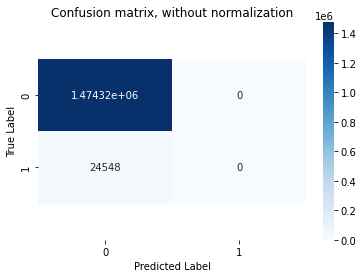

In [19]:
pred_base = base_model.predict(X_test)
conf_matrix(Y_test, pred_base)
print(classification_report(Y_test, pred_base))

In [20]:
dummy_accuracy = base_model.score(X_test, Y_test)
dummy_accuracy 

0.983622285114213

Observamos que la precision del modelo devuelve el mismo porcentaje que el de valores 0 de la variable target. Esto es porque ha predecido correctamente todos estos valores, pero sin embargo a los valores 1 también los ha predecido con 0.

#### La paradoja de precisión

Hemos podido observar que un modelo tan simple como nuestro modelo base tiene una precisión del 98%. Algo que puede parecer excepcional. No obstante esto es una paradoja bastante común con modelos de clasificación de datos desbalanceados. Clases desbalanceadas siempre van a resultar en una precisión distorsionada cuando usamos un modelo que predice en base a la clase mas común. Esto es la paradoja de la precisión para clases desbalanceadas. <br>
Tenemos que usar otra metrica para evaluar como de bien generaliza nuestro modelo.

In [21]:
from sklearn.metrics import precision_recall_curve,plot_roc_curve

### Curva ROC:

Una curva ROC (curva de característica operativa del recepto) es un gráfico que muestra el rendimiento de un modelo de clasificación en todos los umbrales de clasificación. Esta curva representa dos parámetros:

Tasa de verdaderos positivos y Tasa de falsos positivos. <br>
<br>
El AUC proporciona una medición agregada del rendimiento en todos los umbrales de clasificación posibles. Una forma de interpretar el AUC es como la probabilidad de que el modelo clasifique un ejemplo positivo aleatorio más alto que un ejemplo negativo aleatorio.

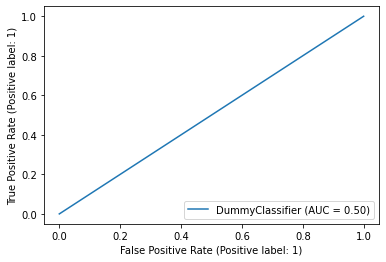

In [22]:
fig, ax = plt.subplots()
plot_roc_curve(base_model,X_test,Y_test,ax=ax);

**Estas métricas de evaluación son mas apropiadas y nos muestran que nuestro modelo base es equivalente a predecir la variable target aleatoriamente** <br>
El valor AUC ('Area under the curve') nos permitirá comparar los distintos modelos que vayamos usando

#### Guardamos el modelo

In [23]:
#función para guardar el modelo
def save_models(filename, model):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

In [24]:
save_models('models/base_model.pkl', base_model )